Testing biological calibration of the Salish Sea Atlantis Model

In [1]:
import os
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import ssam_groups as groups
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [7]:
filename = "v6699_50y_20241105_fisheriesOFF"

In [5]:
data_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Control/" + filename + "/outputSalishSea.nc"

data = xr.open_dataset(str(data_file), decode_cf=True) #[t, box, z]

ssam_time = np.ma.filled(data.variables['t'], np.nan)

diatoms_SSAM_tbz = np.ma.filled(data.variables['Diatom_N'], np.nan)

diatoms_SSAM_tb = diatoms_SSAM_tbz.sum(axis=2)

In [51]:
# Reading in Atlantis map

shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]

In [55]:
strait_of_georgia = [54,64,68,79,62,80,81,82,83,84,85,86,88,90,91,92,94,96,98,101,102]
sog_south = [54,64,68,79]
sog_center = [62,80,81,82,83,84,85]
sog_north = [86,88,90,91,92,94,96,98,101,102]
puget_sound_main = [20,21,23,26]
fraser_river_plume = [75,80,81]

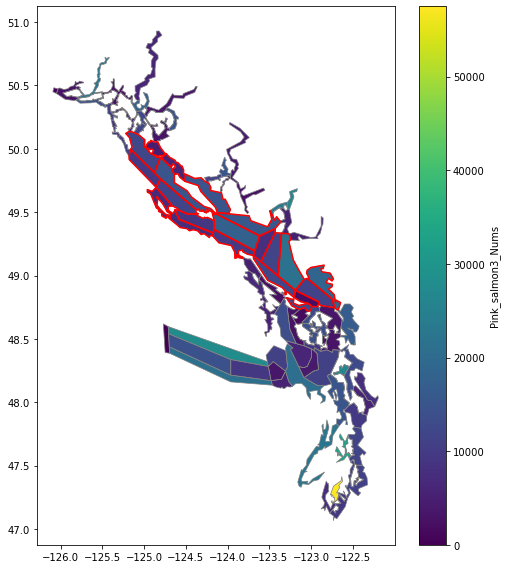

In [65]:
variable_name = 'Pink_salmon3_Nums'
plot_data = data.variables[variable_name][0,:]
data_df['plot_data'] = plot_data.sum(axis=1)
land_df = data_df.loc[land_boxes]
strait_df = data_df.loc[strait_of_georgia]

fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
ax = data_df.plot(column = 'plot_data', ax=ax, cax=cax,#vmin=0, vmax=20, cmap=cm.Greens,
    legend=True, legend_kwds={'label': variable_name
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
strait_df.boundary.plot(ax=ax, color='red');
land_df.plot(ax=ax, color='white');


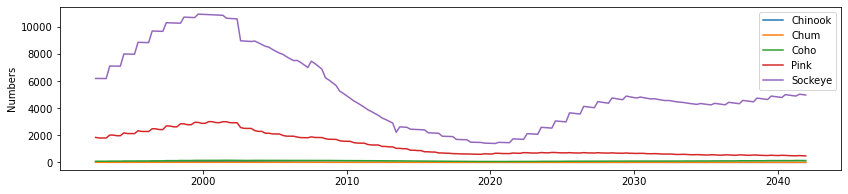

In [57]:
bio_group = groups.wild_salmon
location = strait_of_georgia
fig, ax = plt.subplots(figsize = (14,3))
for species in bio_group:
    time = data.variables['t']
    nums_tbl = data.variables[bio_group[species]+'3_Nums'][:,location,:]
    nums_tb = nums_tbl.sum(axis=2)
    nums_t = nums_tb.sum(axis=1)
    start =  2
    end = time.size

    ax.plot(time[start:end],nums_t[start:end])
ax.legend(bio_group)
ax.set_ylabel('Numbers');

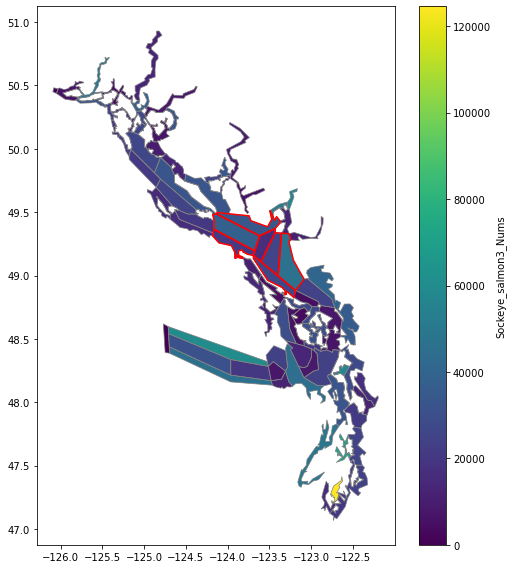

In [66]:
variable_name = 'Sockeye_salmon3_Nums'
plot_data = data.variables[variable_name][0,:]
data_df['plot_data'] = plot_data.sum(axis=1)
land_df = data_df.loc[land_boxes]
strait_df = data_df.loc[sog_center]

fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
ax = data_df.plot(column = 'plot_data', ax=ax, cax=cax,#vmin=0, vmax=20, cmap=cm.Greens,
    legend=True, legend_kwds={'label': variable_name
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
strait_df.boundary.plot(ax=ax, color='red');
land_df.plot(ax=ax, color='white');


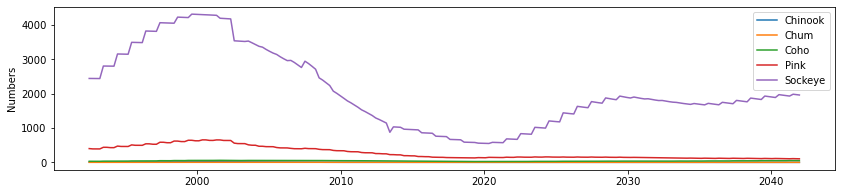

In [67]:
bio_group = groups.wild_salmon
location = sog_center
fig, ax = plt.subplots(figsize = (14,3))
for species in bio_group:
    time = data.variables['t']
    nums_tbl = data.variables[bio_group[species]+'3_Nums'][:,location,:]
    nums_tb = nums_tbl.sum(axis=2)
    nums_t = nums_tb.sum(axis=1)
    start =  2
    end = time.size

    ax.plot(time[start:end],nums_t[start:end])
ax.legend(bio_group)
ax.set_ylabel('Numbers');